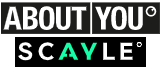

In [1]:
# Load image from local storage
# This library is to create displays
from IPython.display import Image

Image(filename="logo.png", width=200, height=75)

## About You / Scayle Home Assignment

At About You we currently mainly work with an internally developed rule-based attribution model.

If a touchpoint was triggered by a digital marketing channel, we usually have this information and can attribute the corresponding share of the purchase to this channel. This information in combination with the costs for the marketing campaigns help us improve our marketing spend allocation.

One limitation of this model is that our offline marketing campaigns (e.g., TV, radio or billboard advertising) cannot easily be included (because we do not know which sessions were triggered by offline media). However, we have spotted that directly after a TV spot is
aired more customers than we would expect visit our online shop. We decided to use this signal to improve our attribution model.

Task
We have received initial results from our external partner for the TV probability for sessions that occurred on May 15 2020 (“TV data.xlsx”). For the same day you can find session data for Germany in sessions_final.csv
* In sheet “Audience” you can find a list of all tv shows and the audience they reached.
* In sheet “TV Planning” you can find the TV plan for May 2020 including advertising block start times, block sizes (in seconds) and block positions per aired spot (in seconds after start time).
* In sheet “TV spots” you can find an overview of TV spots.
* In sheet “TV - visits match” you can find the estimated TV probabilities per session
Review the data and compare it to your expectation based on your understanding of the described approach for estimating the TV probability of a session. Summarize and visualize your findings.

## Exploratory Data Analysis (EDA)

In this notebook we want to take a detalied look into the data sets, each columns distributions, relationships between data sets and so on.

In [2]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime

# calling functions from the manual created util file
from util import (
    df_first_look,
    file_read,
    sessions_final_df_cleaning,
    countplot_viz,
)

from datetime import datetime
from datetime import timedelta

# adding options to visualise all rows and columns in the project
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# ignoring warnings
warnings.filterwarnings("ignore")

# adding useful magic functions
%load_ext lab_black
%matplotlib inline
%config Completer.use_jedi = False

### Dataset
The data is contained five datesets in two files:

* case_may_2020_sessions_final.csv - Containing identifier, origin, channel and datetime values about each visits.(15th of May)
* case_may_2020_TV_data.xlsx - Containing four sheets as;
    * Audience : Containing spot audience reaching counts for each TV shows.
    * TV planning : Containing spots block details for May 2020.
    * TV spots : Containing spot details. 
    * TV visits match : Containing the estimated TV probabilities per session. 


In [3]:
# Reading all files into the data frames
(
    sessions_final_df,
    audience_df,
    tv_planning_df,
    tv_spots_df,
    tv_visits_match_df,
) = file_read()

## Data Set Overview and Sanity Check
### sessions_final_df: 

In [4]:
df_first_look(sessions_final_df)

First 5 rows of dataframe:
--------------------------
    Unnamed: 0 origin     channel                  identifier date_hour_minute
0           0    app  Direct App  13dd4f3336931ae1e9ad25cdd8   15.05.20 00:00
1           1    app  Direct App  5cf5cc657df461e9d106759592   15.05.20 00:00
2           2    app  Direct App  724351e367f9a4fa8822097365   15.05.20 00:00
3           3    app  Direct App  448ea34d7541666d15a161bf41   15.05.20 00:00
4           4    app  Direct App  b5018d66073c716da53b0afea1   15.05.20 00:00

Last 5 rows of dataframe:
--------------------------
          Unnamed: 0 origin                   channel                        identifier date_hour_minute
1058458     1058447    web                       PSM                940860951026110001   15.05.20 23:59
1058459     1058452    web  Organic Search Non Brand               9229465260410100005   15.05.20 23:59
1058460     1058453    web  Organic Search Non Brand               1840437928708700001   15.05.20 23:59
105846

#### Findings

* There are no null values in the columns
* There are 1058463 rows in the table

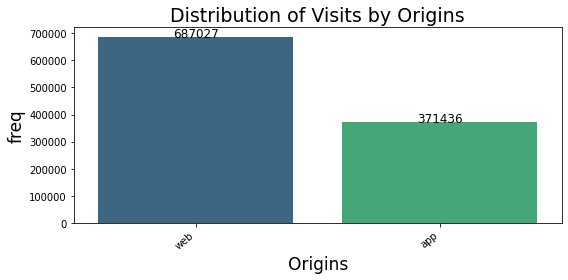

In [5]:
# Visit count by origins:
countplot_viz(
    sessions_final_df,
    "origin",
    "Origins",
    "freq",
    "Distribution of Visits by Origins",
    figsize_x=8,
    figsize_y=4,
    palette="viridis",
)

* There are 2 different origins of the visits. Web visits are almost two times for than app visits. 

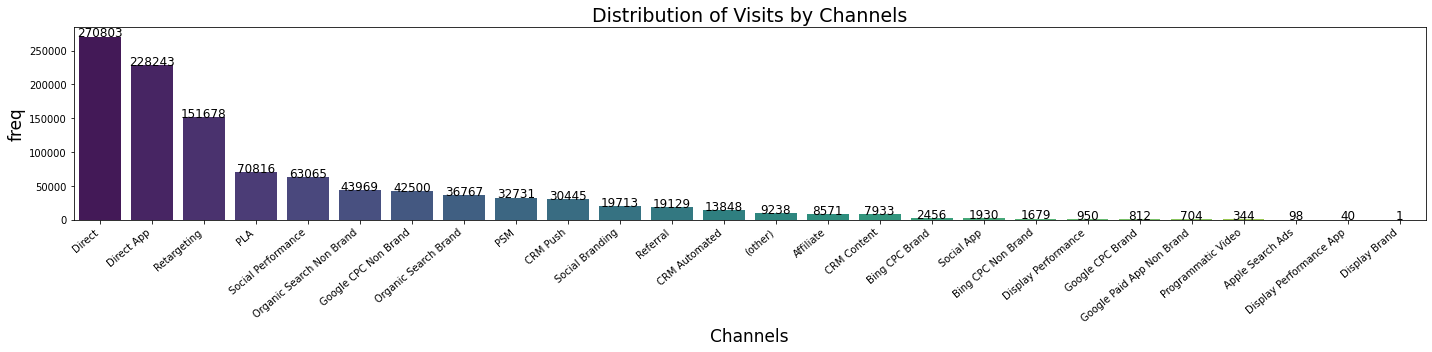

In [6]:
# Visit count by channels:
countplot_viz(
    sessions_final_df,
    "channel",
    "Channels",
    "freq",
    "Distribution of Visits by Channels",
    palette="viridis",
    figsize_x=20,
)

* There are 26 different channels of visits. Direct, Direct App and Retargeting are the most frequent visit channels. 

* For The TV Attribution Case, we'll include a certain list of channels: Search engines (SEO + SEA, Brand) and Direct Type-in Traffic. 

In [7]:
# counting identifiers by date column
visit_count_minute_df = (
    sessions_final_df.groupby(by=["date_hour_minute"])["identifier"]
    .count()
    .reset_index()
)

In [8]:
# changing the format of the date column
visit_count_minute_df["date_hour_minute"] = pd.to_datetime(
    visit_count_minute_df["date_hour_minute"]
)

In [9]:
# adding hour column to be used in the furhter analysis
visit_count_minute_df["date_hour"] = visit_count_minute_df["date_hour_minute"].dt.hour

### Analysing Hourly Visit Distributions

<AxesSubplot:>

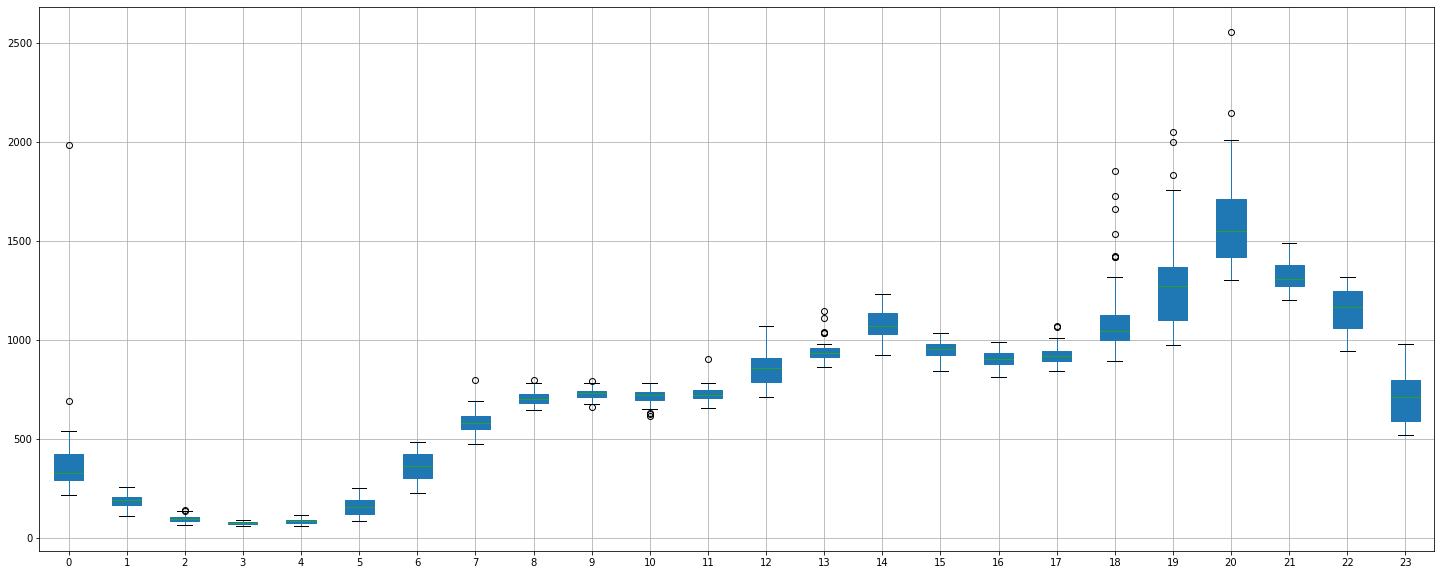

In [10]:
visit_count_minute_df.pivot(columns="date_hour", values="identifier").boxplot(
    figsize=(25, 10), patch_artist=True
)

#### Findings

Regarding the time series box plot we can easily detect that each hour has different behaviours. Here are some key findings;

* `We don't any night owls`: Between 1 and 4 am our visits are in the minimum levels. It is a sign that we shouldn't invest into these time frames for this country.
* `Before work`: Between 5 and 7 am it looks like our users start scratching the surface and check our products. This is a good opportunity to engage some early birds with personalised offers.
* `Do not disturb`: Between 8 and 11 am & 3 and 5 pm our users are at work or quite busy that their behaviours are pretty stable and identical. Making an investment in these hours in this country may not have a huge influence on our visits.
* `Having lunch and searching some gems`: Between 12 am and 2 pm our users are having lunch, enjoying and resting but also reaching out to our products. This is a great opportunity to send reminders to these users before 12 am, e.g. 11:45, to nudge them.
* `Here comes the buyers`: Our users are out of office or dinner with their friends and families (since it is Corona time, probably online ones!) then starting checking our products. As we see highly skewed distributions and many outliers between 6 and 8 pm we can easily say that there are some external factors that changes the behaviours of our users! Who knows maybe TV advertisements!
* `Closing the applications`: Between 9 and 12 pm our users are shutting down their laptops and mobile devices. As we can see the visits are dropping and distributions are getting closer to normal distribution. At these hours people tend not to make big decisions so probably they are adding poroducts to their carts. An early reminder to these users in the next day to nudge them to proceed to the full funnel is a great oportunity without any marketing cost.

### audience_df:

In [11]:
df_first_look(audience_df)

First 5 rows of dataframe:
--------------------------
                                tv_show     reach
0     First Dates - Ein Tisch für zwei   57000.0
1                       SOKO Kitzbühel   95000.0
2                      Alles was zählt   86000.0
3                         Jack Reacher  162000.0
4  Der Bulle von Tölz: Tod aus dem All  150000.0

Last 5 rows of dataframe:
--------------------------
                             tv_show     reach
15        Genial daneben - das Quiz  120000.0
16  Grenzenlos - Die Welt entdecken  140000.0
17                        Unter uns  130000.0
18              Das perfekte Dinner  600000.0
19                  Atlanta Medical  320000.0

Row count of dataframe:
-----------------------
 20 
Column count of dataframe:
--------------------------
 2

List of columns in the dataframe:
---------------------------------
 ['tv_show' 'reach']

Looking NaN values and datatypes of columns in the dataframe:
--------------------------------------------

<class 'pa

#### Findings

* There are no null values in the columns
* There are 20 rows in the table

<AxesSubplot:xlabel='tv_show', ylabel='reach'>

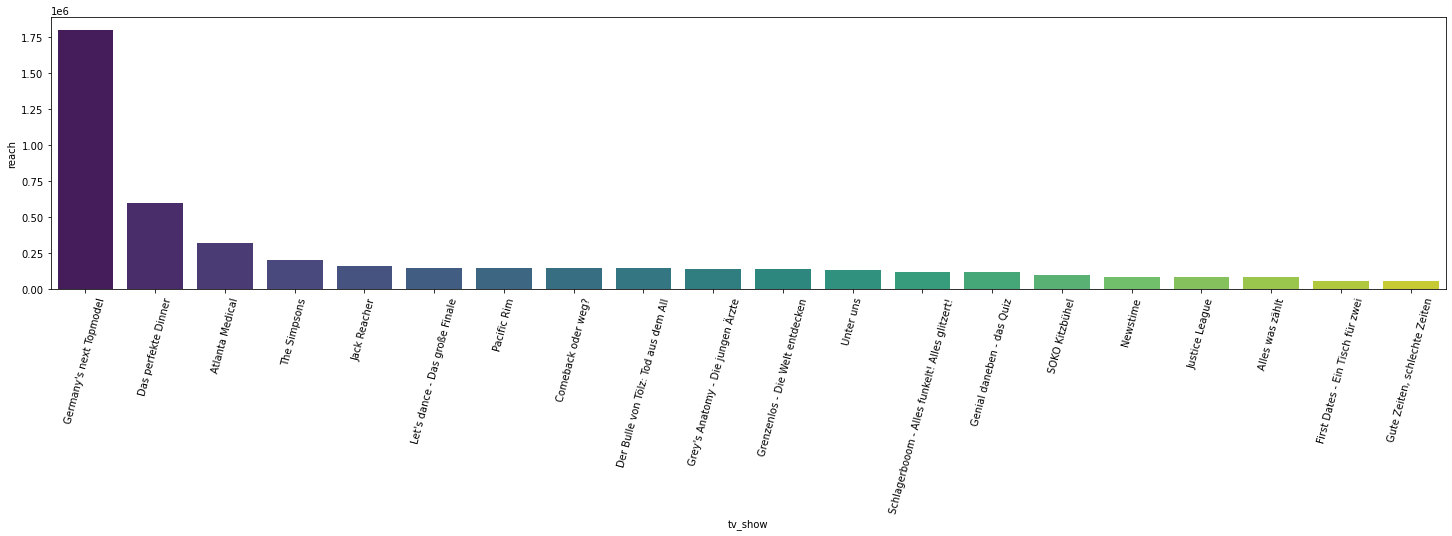

In [12]:
audience_df_sorted = audience_df.sort_values("reach", ascending=False).reset_index()
plt.figure(figsize=(25, 5))
plt.xticks(rotation=75)

sns.barplot(
    x="tv_show",
    y="reach",
    data=audience_df_sorted,
    order=audience_df_sorted["tv_show"],
    palette="viridis",
)

* The most reaching of TV show is "Germany's next Topmodel" and least one is "Gute Zeiten, schlechte Zeitem"

### tv_planning_df:

In [13]:
df_first_look(tv_planning_df)

First 5 rows of dataframe:
--------------------------
                             tvp_id        block_start_time                              tv_show  block_size  block_position  spot_id
0  10001127236681063068_1553644648 2020-05-01 18:15:00.000     First Dates - Ein Tisch für zwei       420.0           345.0   9122.0
1  10001127236681063068_1553644679 2020-05-01 19:36:05.000                      Alles was zählt        60.0            15.0   6561.0
2  10001127236681063068_1553644709 2020-05-01 20:20:00.000  Der Bulle von Tölz: Tod aus dem All       480.0            60.0   4242.0
3  10001127236681063068_1553644649 2020-05-02 18:14:59.995                             Newstime       300.0           270.0   1234.0
4  10001127236681063068_1553644680 2020-05-02 19:36:04.995                   Comeback oder weg?       420.0           345.0   4234.0

Last 5 rows of dataframe:
--------------------------
                              tvp_id        block_start_time                           tv_sho

#### Findings

* There are no null values in the columns

* There are 95 rows in the table

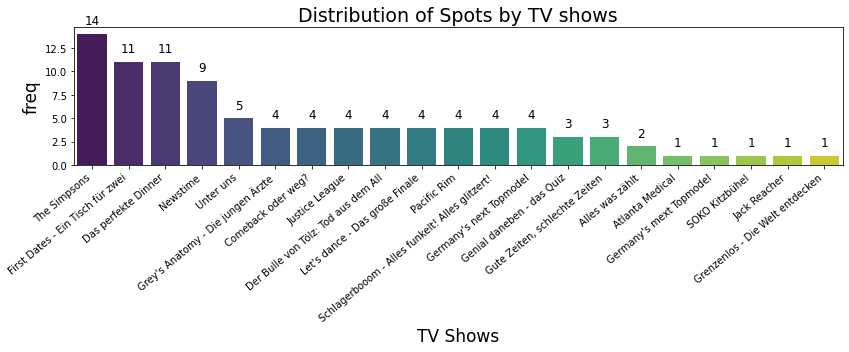

In [14]:
# Spot count by TV shows:
countplot_viz(
    tv_planning_df,
    "tv_show",
    "TV Shows",
    "freq",
    "Distribution of Spots by TV shows",
    palette="viridis",
)

In [15]:
tv_planning_df.groupby(by=["tv_show"])["block_size"].sum().sort_values(
    ascending=False
).reset_index().rename(columns={"block_size": "block_size_total"}).head(3)

,tv_show,block_size_total
0,The Simpsons,4980.0
1,First Dates - Ein Tisch für zwei,3720.0
2,Das perfekte Dinner,3600.0


* The Simpsons, First Dates - Eing Tisch für zwei and Das perfekte Dinner TV shows have the most advertiesement spots and also the longest spot durations.
* The interesting finding is "Germany's mext Topmodel" has the most reach but lowest spot. If there is no legal issue of number of spots can be given to this show, this can be a good opportunity to target.

In [16]:
# We have whole May's data about spot aids. We'll have to clean block_start_time clomn by 15th of May at "Cleaning ana analyze Data" part.
print(
    "Minimum ",
    tv_planning_df["block_start_time"].min(),
    "and maximum dates",
    tv_planning_df["block_start_time"].max(),
    "in the table. As we can see the data set contains a whole 2020 May.",
)

Minimum  2020-05-01 18:15:00 and maximum dates 2020-05-31 20:19:59.995000 in the table. As we can see the data set contains a whole 2020 May.


In [17]:
# Top 3 spot count dates in the data set
tv_planning_df["day"] = tv_planning_df["block_start_time"].dt.day
tv_planning_df.groupby(by=["day"])["tvp_id"].count().sort_values(ascending=False).head(
    3
).reset_index().rename(columns={"tvp_id": "spot_count"})

,day,spot_count
0,15,5
1,1,3
2,17,3


* 15th of May has the most spots in the dataset

In [19]:
# adding hour column to be used in the furhter analysis
tv_planning_df["block_start_time_hour"] = tv_planning_df["block_start_time"].dt.hour

In [22]:
# hourly spot distribution
tv_planning_df.groupby(by=["block_start_time_hour"])["tvp_id"].count().sort_values(
    ascending=False
).reset_index().rename(columns={"tvp_id": "spot_count"})

,block_start_time_hour,spot_count
0,18,32
1,19,32
2,20,31


* During May 2020 we only gave spots between 6 and 8 pm.

### tv_spots_df: 

In [18]:
df_first_look(tv_spots_df)

First 5 rows of dataframe:
--------------------------
    spot_id                    spot_name duration
0     4234        springsummer_branding  30 secs
1     6232  springsummer_outfitfashionA  15 secs
2     7224           springsummer_saleA   7 secs
3     8331           springsummer_saleB   7 secs
4     9122           springsummer_saleC   7 secs

Last 5 rows of dataframe:
--------------------------
    spot_id           spot_name duration
4     9122  springsummer_saleC   7 secs
5     1234            ayas2020  30 secs
6     4242        summer_saleA   7 secs
7     2323        summer_saleB   7 secs
8     6561       launch_flight  30 secs

Row count of dataframe:
-----------------------
 9 
Column count of dataframe:
--------------------------
 3

List of columns in the dataframe:
---------------------------------
 ['spot_id' 'spot_name' 'duration']

Looking NaN values and datatypes of columns in the dataframe:
--------------------------------------------

<class 'pandas.core.frame.DataFr

#### Findings

* There are no null values in the columns

* There are 9 rows in the table

### Tv Spot & TV Planning Bivariate Analysis

In [33]:
pd.merge(tv_planning_df, tv_spots_df, on="spot_id", how="left").groupby(
    by=["spot_name", "duration"]
)["tvp_id"].count().reset_index()

,spot_name,duration,tvp_id
0,ayas2020,30 secs,8
1,launch_flight,30 secs,5
2,springsummer_branding,30 secs,10
3,springsummer_outfitfashionA,15 secs,18
4,springsummer_saleA,7 secs,15
5,springsummer_saleB,7 secs,14
6,springsummer_saleC,7 secs,14
7,summer_saleA,7 secs,6
8,summer_saleB,7 secs,5


## EDA Conclusions and Findings

* Visits are mostly generated by web.
* More than half of the visits are 'Direct' visits, either by web or app. 
* Most of the visits are generated between 6 and 10 pm. The second most important time block is betwen 12 am and 2 pm.
* We only gave spots between 6 and 8pm. For different spot types we may try to target different time frames, e.g. early morning TV shows, kid channels etc.
* Our branding spots are 30 seconds and sales spots are 7 seconds long. We need to identify the affect of giving spots on our visits. According to the results we may consider having smaller but more frequent branding spots. 